In [12]:
import numpy as np
import galsim
import batsim
import matplotlib.pyplot as plt
import tqdm
from scipy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq

0.013802138852538693 4162


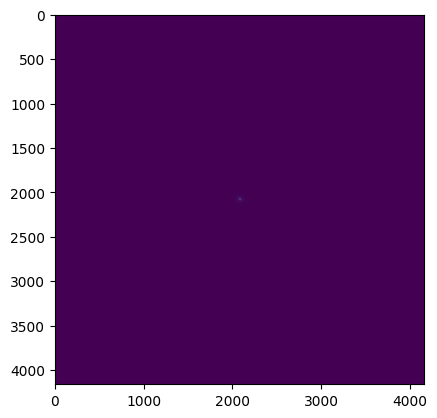

In [13]:
# Choose high Sersic index so a large image is required
gsparams = galsim.GSParams(maximum_fft_size=10000, folding_threshold=5e-3)
sersic = galsim.Sersic(n=4, half_light_radius=1.0, flux=1.0, gsparams=gsparams)
shear_sersic = sersic.shear(g1=0.1, g2=0.1)

# Get nyquist scale and image size
scale = shear_sersic.nyquist_scale
nn = shear_sersic.getGoodImageSize(scale)
print(scale, nn)

# Draw the galaxy
image = shear_sersic.drawImage(nx=nn, ny=nn, scale=scale, method='no_pixel').array
plt.imshow(image)

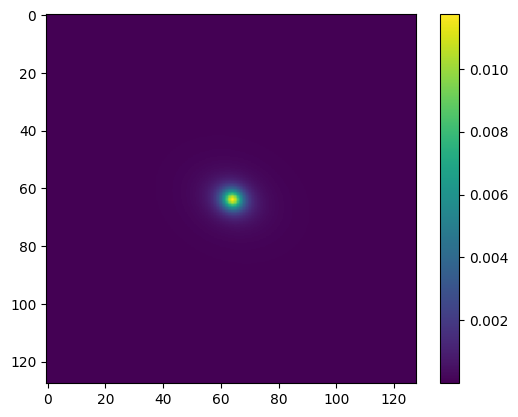

In [14]:
# create PSF obj
psf = galsim.Moffat(beta=3.5, fwhm=0.8, flux=1.0)

galsim_conv = galsim.Convolve([shear_sersic, psf])

draw_scale = 0.2
draw_size = 128

gs_image = galsim_conv.shift(0.5*draw_scale, 0.5*draw_scale).drawImage(nx=draw_size, ny=draw_size, 
                                                             scale=draw_scale, method='auto').array

plt.imshow(gs_image)
plt.colorbar()

### Implement Pythonic example of how BATSim could handle PSF convolution
- Once this is working move to C++ and figure out how best to structure within stamp class to make process intuitive

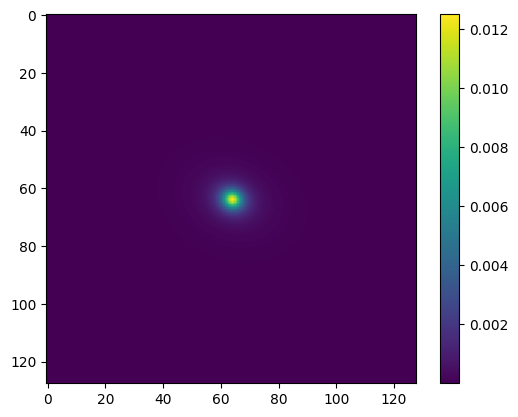

In [15]:
# draw and sample galaxy in BATSim
galstamp = batsim.Stamp(nn=nn, scale=scale)
Lens = batsim.LensTransform(gamma1=0.1, gamma2=0.1, kappa=0.0)
galstamp.transform_grids(Lens)
galprof = galstamp.sample_galaxy(sersic)
galprof /= np.sum(galprof) / sersic.flux # Normalize galaxy

# draw and sample PSF in BATSim
psf_nn = psf.getGoodImageSize(scale)
psfstamp = batsim.Stamp(nn=psf_nn, scale=scale)
psfprof = psfstamp.sample_galaxy(psf)
psfprof /= np.sum(psfprof) / psf.flux  # Normalize PSF

# Pad PSF array to the same shape as galprof
pad_width = ((nn - psf_nn) // 2,)
psfprof_pad = np.pad(psfprof, pad_width, mode='constant', constant_values=0)

galKprof = fftshift(fft2(galprof))
psfKprof = fftshift(fft2(psfprof_pad))

# Multiply the two profiles in Fourier space
convKprof = galKprof * psfKprof

# crop the Fourier image to set pixel scale to drawing scale
pixel_factor =  draw_scale / scale
nn_cut = int(nn / pixel_factor)
maxN = nn//2 + nn_cut//2
minN = nn//2 - nn_cut//2
convKprof = convKprof[minN:maxN, minN:maxN]

# Inverse Fourier transform to obtain convolution result in real space
conv_im = ifftshift(ifft2(fftshift(convKprof)))
conv_im = conv_im.real # Throw away imaginary part
conv_size = np.shape(conv_im)[0]

# crop or pad the real space image to the desired size
if conv_size < draw_size:
    # pad image in real space
    pad_width = ((draw_size - conv_size) // 2,)
    conv_im = np.pad(conv_im, pad_width, mode='constant', constant_values=0)
elif conv_size > draw_size:
    # crop image in real space
    maxN = conv_size//2 + draw_size//2
    minN = conv_size//2 - draw_size//2
    conv_im = conv_im[minN:maxN, minN:maxN]

plt.imshow(conv_im)
plt.colorbar()

0.9798729 0.9826067607116613


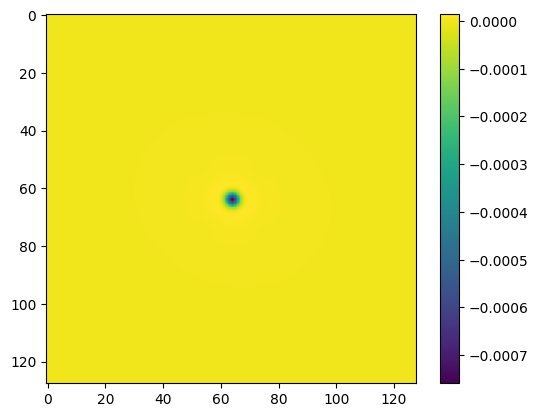

In [16]:
# Check fluxes are normalised correctly(ish)
print(np.sum(gs_image), np.sum(conv_im))
plt.imshow(gs_image-conv_im)
plt.colorbar()